In [ ]:
import os, json, sys, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from llama_index.core import Settings
from llama_index.core.schema import TextNode
from llama_index.core.vector_stores.simple import SimpleVectorStoreData, SimpleVectorStore, VectorStoreQuery
from llama_index.core.vector_stores.types import MetadataFilters, FilterOperator
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.graph_stores.nebula import NebulaPropertyGraphStore
from pyhpo import Ontology
from typing import List
from nebulagraph_lite import nebulagraph_let as ng_let
from tqdm import tqdm

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Set up

## Datasets

In [2]:
# load the phenopackets data
output_file = os.path.expanduser('~/scratch-llm/storage/phenopackets/phenopacket_data.json')
with open(output_file, 'r') as f:
    phenopackets = json.load(f)

In [3]:
# load results from DiseaseMode data from the phenopackets
results_file = os.path.expanduser('~/scratch-llm/storage/phenopackets/disease_rag_results.json')
with open(results_file, 'r') as f:
    rag_results = json.load(f)

results_file = os.path.expanduser('~/scratch-llm/storage/phenopackets/disease_no_rag_results.json')
with open(results_file, 'r') as f:
    no_rag_results = json.load(f)

## Embedidng model, graph and vector store

In [4]:
Settings.embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-mpnet-base-v2") # BAAI/bge-small-en-v1.5 /  m3 / sentence-transformers/all-mpnet-base-v2

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SimpleVectorStore:

In [5]:
with open(os.path.expanduser('~/scratch-llm/storage/nodes/all_nodes_all-mpnet-base-v2.pkl'), 'rb') as f:
    all_nodes_embedded: List[TextNode] = pickle.load(f)
# Create dictionaries from the nodes
embedding_dict = {node.id_: node.get_embedding() for node in all_nodes_embedded}
text_id_to_ref_doc_id = {node.id_: node.ref_doc_id or "None" for node in all_nodes_embedded}
metadata_dict = {node.id_: node.metadata for node in all_nodes_embedded}

# Initialize the SimpleVectorStore with the dictionaries
vector_store = SimpleVectorStore(
    data = SimpleVectorStoreData(
        embedding_dict=embedding_dict,
        text_id_to_ref_doc_id=text_id_to_ref_doc_id,
        metadata_dict=metadata_dict,
    ),
    stores_text=True
)

GraphStore:

In [6]:
n = ng_let(in_container=True)
n.start() # Takes around 5 mins

Message: Activating storaged...
Result of `SHOW HOSTS`:
    errors:
        code: 0
    results:
        spaceName: 
        data:
            meta:
                None, None, None, None, None, None, None
            row:
                127.0.0.1, 9779, ONLINE, 101, PrimeKG:100, basketballplayer:1, PrimeKG:100, basketballplayer:1, 3.8.0
        columns:
            Host, Port, Status, Leader count, Leader distribution, Partition distribution, Version
        errors:
            code: 0
        latencyInUs: 1066
Info: loading basketballplayer dataset...

  _   _      _           _        ____                 _     
 | \ | | ___| |__  _   _| | __ _ / ___|_ __ __ _ _ __ | |__  
 |  \| |/ _ | '_ \| | | | |/ _` | |  _| '__/ _` | '_ \| '_ \ 
 | |\  |  __| |_) | |_| | | (_| | |_| | | | (_| | |_) | | | |
 |_| \_|\___|_.__/ \__,_|_|\__,_|\____|_|  \__,_| .__/|_| |_|
                                                |_|          
                                                lite version

[ OK

In [7]:
graph_store = NebulaPropertyGraphStore(
    space = "PrimeKG",
    username = "root",
    password = "nebula",
    url = "nebula://localhost:9669",
    props_schema= """`node_index` STRING, `node_type` STRING, `node_id` STRING, `node_name` STRING, 
        `node_source` STRING, `mondo_id` STRING, `mondo_name` STRING, `group_id_bert` STRING, 
        `group_name_bert` STRING, `orphanet_prevalence` STRING, `display_relation` STRING """,
)

# Evaluation

Map each symptom to the closest HPO term:<br>
(using the Vector and Graph store with the embedded nodes)

In [ ]:
_ = Ontology()

In [165]:
def find_HPO_embedding(symptoms: List[str]) -> List[str]:
    phenotype_dict = {
        "key": "node_type",
        "value": "effect/phenotype",
        "operator": FilterOperator.EQ
    }
    phenotype_filter = MetadataFilters(filters=[phenotype_dict])
    new_symptoms = []
    for term in symptoms:
        term = term.strip()
        try: 
            if Ontology.get_hpo_object(term.capitalize()):
                new_symptoms.append(term.capitalize())

        except RuntimeError:
            query_embedding = Settings.embed_model.get_text_embedding(term)
            vector_results = vector_store.query(
                VectorStoreQuery(
                    query_embedding=query_embedding, 
                    similarity_top_k=1,
                    filters=phenotype_filter,
                )
            )
            if not vector_results.ids or len(vector_results.ids) == 0:
                print(f"Warning: No vector IDs found for term '{term}'")
                continue
            
            kg_node = graph_store.get(ids=[vector_results.ids[0]])
            if kg_node and len(kg_node) > 0:
                hpo_name = kg_node[0].properties['node_name'] if kg_node else None
                # print(f"Term: {term} | Vector ID: {vector_results.ids[0]} | KG node: {hpo_name} | Similarity: {vector_results.similarities[0]:.4f}")
                if vector_results.similarities[0] > 0.5 and kg_node:
                    new_symptoms.append(hpo_name)
            else:
                print(f"Term: {term} | No KG node found for vector ID: {vector_results.ids[0]}")
                continue
    return list(set(new_symptoms))

procesing of the diseases:

In [ ]:

results = []
for disease in tqdm(list(phenopackets.keys()), desc="Processing diseases"):
    # find the disease in the rag and no_rag results

    rag_result = rag_results.get(disease, None) 
    no_rag_result = no_rag_results.get(disease, None) 
    
    if rag_result is not None and no_rag_result is not None:
        common_symptoms = set(r.lower() for r in rag_result['symptoms']).intersection(set(n.lower() for n in no_rag_result['symptoms'])) if rag_result and no_rag_result else []
        rag_matches = set(s.lower() for s in rag_result['symptoms']).intersection(set(d.lower() for d in phenopackets[disease])) if rag_result else set()
        no_rag_matches = set(s.lower() for s in no_rag_result['symptoms']).intersection(set(d.lower() for d in phenopackets[disease])) if no_rag_result else set()

        # ensure HPO terms are used for symptom
        rag_result['symptoms'] = find_HPO_embedding(rag_result['symptoms']) if rag_result['symptoms'] else []
        no_rag_result['symptoms'] = find_HPO_embedding(no_rag_result['symptoms']) if no_rag_result['symptoms'] else []

        common_symptoms_hpo = set(r.lower() for r in rag_result['symptoms']).intersection(set(n.lower() for n in no_rag_result['symptoms'])) if rag_result and no_rag_result else []
        rag_matches_hpo = set(s.lower() for s in rag_result['symptoms']).intersection(set(d.lower() for d in phenopackets[disease])) if rag_result else set()
        no_rag_matches_hpo = set(s.lower() for s in no_rag_result['symptoms']).intersection(set(d.lower() for d in phenopackets[disease])) if no_rag_result else set()

        
        count_rag = 0
        for symptom in rag_result['symptoms']:
            try: 
                hpo_term = Ontology.get_hpo_object(symptom)
            except RuntimeError:
                hpo_term = None
            if hpo_term:
                if hpo_term.parents:
                    for parent in hpo_term.parents:
                        parent_name = parent.name

                        # check if parent_name is in the phenopackets data
                        if parent_name.lower() in [d.lower() for d in phenopackets[disease]]:
                            count += 1
                else:
                    continue
            else:
                continue
        
        count_no_rag = 0
        for symptom in no_rag_result['symptoms']:
            try: 
                hpo_term = Ontology.get_hpo_object(symptom)
            except RuntimeError:
                hpo_term = None
            if hpo_term:
                if hpo_term.parents:
                    for parent in hpo_term.parents:
                        parent_name = parent.name

                        # check if parent_name is in the phenopackets data
                        if parent_name.lower() in [d.lower() for d in phenopackets[disease]]:
                            count_no_rag += 1
                else:
                    continue
            else:
                continue
                    

        results.append({
            "disease": disease,
            "common_symptoms": len(common_symptoms), # matches between rag and no_rag
            "rag_matches": len(rag_matches), # matches between rag and dataset
            "no_rag_matches": len(no_rag_matches), # matches between no_rag and dataset
            "common_symptoms_hpo": len(common_symptoms_hpo), # matches between rag and no_rag using HPO terms
            "rag_matches_hpo": len(rag_matches_hpo) + count_rag, # matches between rag and dataset using HPO terms
            "no_rag_matches_hpo": len(no_rag_matches_hpo) + count_no_rag, # matches between no_rag and dataset using HPO terms
            "rag_accuracy": 0.0, # not sure if these are relevant...
            "rag_accuracy_hpo": 0.0,
            "no_rag_accuracy": 0.0,
            "no_rag_accuracy_hpo": 0.0,
            "total_symptoms": len(phenopackets[disease])

        })
    else:
        print(f"{disease} was not found in rag or no_rag results")
        continue

Processing diseases:  16%|█▌        | 8/50 [00:05<00:27,  1.53it/s]

Myotonia congenita, dominant was not found in rag or no_rag results


Processing diseases:  54%|█████▍    | 27/50 [00:18<00:08,  2.66it/s]

Muscular dystrophy, limb-girdle, autosomal recessive 29 was not found in rag or no_rag results


Processing diseases: 100%|██████████| 50/50 [00:37<00:00,  1.34it/s]


/tmp/ipykernel_3784098/3161014767.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


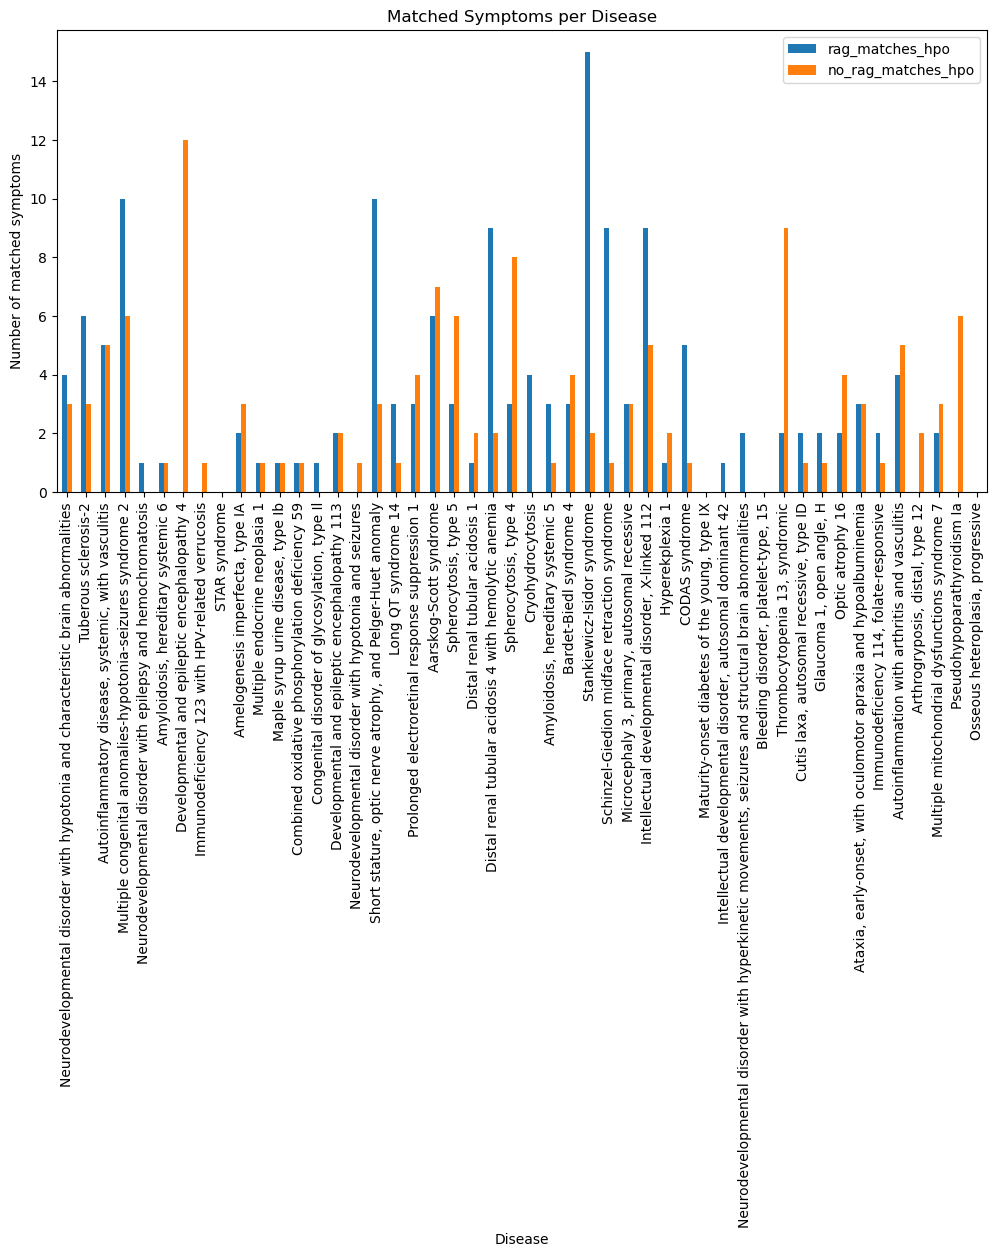

In [ ]:
df = pd.DataFrame(results)
df.plot(
    x="disease",
    y=["rag_matches_hpo", "no_rag_matches_hpo"],
    kind="bar",
    title="Matched Symptoms per Disease",
    ylabel="Number of matched symptoms",
    xlabel="Disease",
    figsize=(12, 6)
)
plt.tight_layout()
plt.show()

In [176]:
# count the percentage of diseases with more rag matches, no_rag matches, and equal matches from the results
rag_more_than_no_rag = (df['rag_matches'] > df['no_rag_matches']).sum() / len(df) * 100
no_rag_more_than_rag = (df['no_rag_matches'] > df['rag_matches']).sum() / len(df) * 100
equal_matches = (df['rag_matches'] == df['no_rag_matches']).sum() / len(df) * 100
print(f"Percentage of diseases with more RAG matches than no RAG: {rag_more_than_no_rag:.2f}%")
print(f"Percentage of diseases with more no RAG matches than RAG: {no_rag_more_than_rag:.2f}%")
print(f"Percentage of diseases with equal matches: {equal_matches:.2f}%")


Percentage of diseases with more RAG matches than no RAG: 47.92%
Percentage of diseases with more no RAG matches than RAG: 18.75%
Percentage of diseases with equal matches: 33.33%


In [177]:
n.stop() # Stop the NebulaGraph service


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


udocker command: udocker /home/lasa14/.conda/envs/llm-rag/bin/udocker --allow-root ps | grep graphd | awk '{print $1}' | xargs -I {} udocker --allow-root rm -f {}
error: Error: deleting directory:  /home/lasa14/.udocker/containers/c96637d3-6f85-38e2-b796-a40f10a8443b
Error: deleting container

Retrying in 5 seconds... udocker command failed with return code 123


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


udocker command: udocker /home/lasa14/.conda/envs/llm-rag/bin/udocker --allow-root ps | grep graphd | awk '{print $1}' | xargs -I {} udocker --allow-root rm -f {}
error: Error: deleting directory:  /home/lasa14/.udocker/containers/c96637d3-6f85-38e2-b796-a40f10a8443b
Error: deleting container

Retrying in 15 seconds... udocker command failed with return code 123


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


udocker command: udocker /home/lasa14/.conda/envs/llm-rag/bin/udocker --allow-root ps | grep graphd | awk '{print $1}' | xargs -I {} udocker --allow-root rm -f {}
error: Error: deleting directory:  /home/lasa14/.udocker/containers/c96637d3-6f85-38e2-b796-a40f10a8443b
Error: deleting container

Process with PID 3788595 has been terminated.
Process with PID 3785588 has been terminated.
